In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
def is_van_gogh(artist_name: str) -> int:
    return int("van-gogh" in artist_name.lower())


In [11]:
import wandb
# שים לב לשם הפרמטר key
wandb.login(key="2d0501f02cef1761c98b984600a9770322929664")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

 # ****Data**** ****Preparation**** 

In [10]:
import os
import pandas as pd

base_dir = "/kaggle/input/wikiart/Post_Impressionism"

records = []

for fname in os.listdir(base_dir):
    if not fname.lower().endswith((".jpg", ".png")):
        continue

    artist = fname.split("_")[0] #takes the first item of the split- the name of artist

    records.append({
        "filepath": os.path.join(base_dir, fname),
        "artist": artist,
        "is_van_gogh": int("van-gogh" in artist.lower())
    })

df = pd.DataFrame(records)


##  **check** **the** **dataframe**

In [11]:
df.head()

,filepath,artist,is_van_gogh
0,/kaggle/input/wikiart/Post_Impressionism/paul-...,paul-cezanne,0
1,/kaggle/input/wikiart/Post_Impressionism/suzan...,suzanne-valadon,0
2,/kaggle/input/wikiart/Post_Impressionism/alber...,albert-marquet,0
3,/kaggle/input/wikiart/Post_Impressionism/vince...,vincent-van-gogh,1
4,/kaggle/input/wikiart/Post_Impressionism/paul-...,paul-gauguin,0


In [12]:
print (df["is_van_gogh"].value_counts())
print (df[df["is_van_gogh"] == 1].head())

is_van_gogh
0    5445
1    1005
Name: count, dtype: int64
                                             filepath            artist  \
3   /kaggle/input/wikiart/Post_Impressionism/vince...  vincent-van-gogh   
9   /kaggle/input/wikiart/Post_Impressionism/vince...  vincent-van-gogh   
16  /kaggle/input/wikiart/Post_Impressionism/vince...  vincent-van-gogh   
17  /kaggle/input/wikiart/Post_Impressionism/vince...  vincent-van-gogh   
18  /kaggle/input/wikiart/Post_Impressionism/vince...  vincent-van-gogh   

    is_van_gogh  
3             1  
9             1  
16            1  
17            1  
18            1  


## *splitting the dataframe, and check it*

In [15]:
from sklearn.model_selection import train_test_split

# Step 1: Initial split - 70% for training and 30% for a temporary set (temp_df)
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,           # Reserves 30% of the data for validation and testing
    stratify=df["is_van_gogh"], # Ensures class proportions are preserved across splits
    random_state=42          # Sets a seed for reproducibility
)

# Step 2: Second split - Divide the 30% temporary set equally into validation and test sets
# This results in 15% of the total data for validation and 15% for testing
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,           # Splits the 30% into two equal 15% parts
    stratify=temp_df["is_van_gogh"], # Maintains class balance in the remaining subsets
    random_state=42
)

In [16]:
# Calculate the total number of rows
total_count = len(df)

# Print percentages of each split relative to the original dataset
print(f"Train set: {len(train_df)} rows ({len(train_df) / total_count:.1%})")
print(f"Val set:   {len(val_df)} rows ({len(val_df) / total_count:.1%})")
print(f"Test set:  {len(test_df)} rows ({len(test_df) / total_count:.1%})")

print("-" * 30)

# Print class distribution (counts) to verify stratification
print("Class distribution per split:")
print("\nTrain:\n", train_df["is_van_gogh"].value_counts(normalize=True)) # normalize=True gives ratios
print("\nVal:\n",   val_df["is_van_gogh"].value_counts(normalize=True))
print("\nTest:\n",  test_df["is_van_gogh"].value_counts(normalize=True))

Train set: 4515 rows (70.0%)
Val set:   967 rows (15.0%)
Test set:  968 rows (15.0%)
------------------------------
Class distribution per split:

Train:
 is_van_gogh
0    0.844075
1    0.155925
Name: proportion, dtype: float64

Val:
 is_van_gogh
0    0.844881
1    0.155119
Name: proportion, dtype: float64

Test:
 is_van_gogh
0    0.844008
1    0.155992
Name: proportion, dtype: float64


### Trasfomation class for VGG & AlexNet standard

In [17]:
from torchvision import transforms
"""
1 Standard transformations for models pre-trained on ImageNet ( VGG, AlexNet)
2 Resizes the image to 224x224, the standard input size for VGG and AlexNet
3 Converts the image to a PyTorch tensor and scales pixels to the [0, 1] range
4 Normalizes the tensor using ImageNet's mean and standard deviation.
5 Essential for maintaining consistency with VGG and AlexNet pre-trained weights.


augmentaion used: 
- RandomResizedCrop: Crops a random portion of the image and resizes it to 224x224. 
  This helps the model become invariant to scale and object position.
- RandomHorizontalFlip: Flips the image horizontally with a 50% probability. 
  Useful for art since composition can be mirrored without losing stylistic meaning.
- RandomRotation: Rotates the image by up to 10 degrees to handle slight tilts.
- ColorJitter: Randomly changes brightness, contrast, saturation, and hue. 
  This is crucial for Van Gogh's work as it makes the model robust to different lighting 
  conditions and minor color shifts in art photography.
- ToTensor & Normalize: Standard ImageNet preprocessing for model compatibility.
"""
# will be used to trasform the images to normalized tensor object  --> base_transform(un-normalized picture) and the Augmentaions

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [18]:
# Like the Train transforom but without the augmentaions

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

### Making Dataset Object

In [19]:
from torch.utils.data import Dataset
from PIL import Image

class VanGoghDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)   
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image = Image.open(row["filepath"]).convert("RGB")
        label = row["is_van_gogh"]

        if self.transform:
            image = self.transform(image)

        return image, label


In [20]:
train_dataset = VanGoghDataset(train_df, transform=train_transform)
val_dataset   = VanGoghDataset(val_df,   transform=eval_transform)
test_dataset  = VanGoghDataset(test_df,  transform=eval_transform)


In [21]:
train_dataset[0][0]

tensor([[[-1.8439, -1.8439, -1.8439,  ..., -1.8439, -1.8439, -1.8439],
         [-1.8439, -1.8439, -1.8439,  ..., -1.8439, -1.8439, -1.8439],
         [-1.8439, -1.8439, -1.8439,  ..., -1.8439, -1.8439, -1.8439],
         ...,
         [-1.8439, -1.8439, -1.8439,  ..., -1.8439, -1.8439, -1.8439],
         [-1.8439, -1.8439, -1.8439,  ..., -1.8439, -1.8439, -1.8439],
         [-1.8439, -1.8439, -1.8439,  ..., -1.8439, -1.8439, -1.8439]],

        [[-1.7556, -1.7556, -1.7556,  ..., -1.7556, -1.7556, -1.7556],
         [-1.7556, -1.7556, -1.7556,  ..., -1.7556, -1.7556, -1.7556],
         [-1.7556, -1.7556, -1.7556,  ..., -1.7556, -1.7556, -1.7556],
         ...,
         [-1.7556, -1.7556, -1.7556,  ..., -1.7556, -1.7556, -1.7556],
         [-1.7556, -1.7556, -1.7556,  ..., -1.7556, -1.7556, -1.7556],
         [-1.7556, -1.7556, -1.7556,  ..., -1.7556, -1.7556, -1.7556]],

        [[-1.5256, -1.5256, -1.5256,  ..., -1.5256, -1.5256, -1.5256],
         [-1.5256, -1.5256, -1.5256,  ..., -1

In [22]:
import torch
# sanity check
# Retrieve images only (index 0 of the returned tuple)
img1 = test_dataset[0][0]
img2 = test_dataset.__getitem__(0)[0]
print(torch.equal(img1, img2)) 



True


In [23]:
from torch.utils.data import DataLoader

# DataLoader for the training set
train_loader = DataLoader(
    train_dataset,
    batch_size=32,      # Number of images per training step
    shuffle=True,       # Shuffle the data to prevent the model from learning the order
    num_workers=2       # Use 2 parallel CPU processes to load data faster - BUT WE ARE ON GPU
)

# DataLoader for the validation set
val_loader = DataLoader(
    val_dataset,
    batch_size=32,      # Typically matches the training batch size -- TO CHECK
    shuffle=False,      # No need to shuffle during evaluation
    num_workers=2
)

### Making  DataLoader obj to later use in our model

# Model Training & Tuning


In [24]:
import torch

# הגדרת המכשיר - אם יש GPU ב-Kaggle, הוא ישתמש בו
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on: {device}") # ב-Kaggle זה צריך להדפיס cuda


Working on: cuda


In [25]:
from torchvision import models
from torch import nn

model = models.vgg19(pretrained=True)

model.classifier[-1] = nn.Linear(
    model.classifier[-1].in_features, 2
)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 221MB/s] 


In [26]:
# Print only the last layer of the classifier
print(model.classifier[-1])

Linear(in_features=4096, out_features=2, bias=True)


In [27]:
# maybe not neeeded code

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [28]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()    # each grad will start with grad = zero
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        # בדיקה אם יש ריצה פעילה ב-W&B כדי למנוע את השגיאה שקיבלת
        if wandb.run is not None:
            wandb.log({"batch_loss": loss.item()})

    return total_loss / len(loader)

@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        if wandb.run is not None:
            wandb.log({"val_batch_loss": loss.item()})
            
    return total_loss / len(loader), correct / total

In [26]:
# run = wandb.init(
#     project="VanGogh_Classifier", 
#     name="Initial_Test",
#     config={
#         "architecture": "VGG19",
#         "epochs": 3
#     }
# )


# for epoch in range(num_epochs):
#     train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
#     val_loss, val_acc = eval_one_epoch(model, val_loader, criterion)
#     # ...

# run.finish()

KeyboardInterrupt: 

In [31]:
def objective(trial):
    # 1. בחירת היפר-פרמטרים + בחירת מודל
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    
    # הוספת בחירת המודל כפרמטר
    model_name = trial.suggest_categorical("model_name", ["VGG19", "AlexNet"])
    
    # הגדרת ה-DataLoaders
    curr_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    curr_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # 2. אתחול ריצה ב-W&B (מעודכן עם שם המודל שנבחר)
    run = wandb.init(
        project="VanGogh_Classifier_Comparison",
        name=f"{model_name}_trial_{trial.number}",
        config={
            "lr": lr, 
            "optimizer": optimizer_name, 
            "batch_size": batch_size,
            "model": model_name
        },
        reinit=True
    )

    # 3. בניית המודל שנבחר
    if model_name == "VGG19":
        model = models.vgg19(pretrained=True)
        # ב-VGG19 השכבה האחרונה היא בדרך כלל ב-index 6 של ה-classifier
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
    else: # AlexNet
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
        
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    
    # 4. לולאת אימון (5 Epochs)
    num_epochs = 5 
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, curr_train_loader, optimizer, criterion)
        val_loss, val_acc = eval_one_epoch(model, curr_val_loader, criterion)
        
        wandb.log({
            "epoch": epoch,
            "loss/train": train_loss, 
            "loss/val": val_loss,
            "accuracy/val": val_acc,
            "model_type": model_name
        })
        
        trial.report(val_acc, epoch)
        if trial.should_prune():
            run.finish()
            raise optuna.exceptions.TrialPruned()

    run.finish()
    return val_acc

VGG 45 minute no freeze 

In [32]:
import optuna
import torch
import torch.nn as nn
from torchvision import models
# יצירת המחקר
study = optuna.create_study(direction="maximize")

# הרצה לבדיקה ראשונית - 5 דקות בלבד (300 שניות)
study.optimize(objective, timeout=3600) 

print("--- הבדיקה הסתיימה בהצלחה! ---")
print("הפרמטרים הטובים ביותר שמצאנו ב-45 דקות:", study.best_params)

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():
[I 2026-01-06 19:03:29,023] A new study created in memory with name: no-name-8038ee7e-c210-4161-9345-842783db9703
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


accuracy/val,▁▆█▆█
batch_loss,▄▂▆▄▃▃▃▇▃█▇▂▇▄▃▅▂▄▁▃▄▃▅▅▁▆▄▃▅▄▂▆▂▃▁▆▅▃▁▃
epoch,▁▃▅▆█
loss/train,█▄▃▂▁
loss/val,█▄▂▂▁
val_batch_loss,▄▄▄█▁▃█▃▄▂▂▃▂▃▄▃▂▄▆▄▁▂▇▇▅▅▄▂▂▂▁▁▇▄▁▁▁▃▁▂
accuracy/val,0.95243
batch_loss,0.01463
epoch,4
loss/train,0.12641
loss/val,0.14303


[I 2026-01-06 19:13:32,021] Trial 0 finished with value: 0.9524301964839711 and parameters: {'lr': 0.008952345253723756, 'optimizer': 'SGD', 'batch_size': 16, 'model_name': 'VGG19'}. Best is trial 0 with value: 0.9524301964839711.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


accuracy/val,▁▂▂▃█
batch_loss,▃▂▄▃▃▃█▄▂▁▅▃▂▁▃▂▃▂▂▂▃▁▃▁▃▃▁▂▂▁▁▁▁▄▂▂▂▄▁▂
epoch,▁▃▅▆█
loss/train,█▅▃▁▁
loss/val,█▄▄▅▁
val_batch_loss,▁▄▄▁▄▄▂▂▃▃▃▂█▄▃▂▃▂▂▂▃▁▃▁▆▄▁▁▁▇▂▁▂▅▄▅▄▁▄▂
accuracy/val,0.95243
batch_loss,0.22631
epoch,4
loss/train,0.1249
loss/val,0.12189


[I 2026-01-06 19:23:02,102] Trial 1 finished with value: 0.9524301964839711 and parameters: {'lr': 4.0412803688180614e-05, 'optimizer': 'Adam', 'batch_size': 16, 'model_name': 'VGG19'}. Best is trial 0 with value: 0.9524301964839711.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


accuracy/val,▁▆▇▇█
batch_loss,▄█▄▄█▃▃▂▆▃▃▃▄▄▂▃▂▄▂▂▂▂▂▂▃█▂▅▂▂▁▂▁▁▄▁▂▁▁▂
epoch,▁▃▅▆█
loss/train,█▄▃▁▁
loss/val,█▃▂▂▁
val_batch_loss,▄▆▇█▄▄▃▁▅▂▃▅▁▇▂▂▇▅▁▄▁▃▁█▂▅▃▆▂▂▁▂▅▆▄▁▆▂▅▂
accuracy/val,0.94933
batch_loss,0.03296
epoch,4
loss/train,0.13348
loss/val,0.13678


[I 2026-01-06 19:32:18,537] Trial 2 finished with value: 0.9493278179937953 and parameters: {'lr': 0.0017630944870202685, 'optimizer': 'SGD', 'batch_size': 16, 'model_name': 'VGG19'}. Best is trial 0 with value: 0.9524301964839711.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 217MB/s] 


accuracy/val,▁▅▆▇█
batch_loss,█▄▅▄▅▃▃▅▄▃▃▃▄▄▃▃▄▂▅▅▄▃▃▅▃▂▃▃▄▂▃▂▃▃▂▁▄▂▂▁
epoch,▁▃▅▆█
loss/train,█▄▂▂▁
loss/val,█▅▃▂▁
val_batch_loss,▃█▅▄▅▆▅▇▆▃▄▆▄▃▄▅▅▄▄▆▆▁▃▃▅▂▅▂▅▃▄▂▂▃▂▃▂▃▁▂
accuracy/val,0.90383
batch_loss,0.28954
epoch,4
loss/train,0.28421
loss/val,0.25276


[I 2026-01-06 19:40:21,974] Trial 3 finished with value: 0.9038262668045501 and parameters: {'lr': 0.0002739669378902632, 'optimizer': 'SGD', 'batch_size': 64, 'model_name': 'AlexNet'}. Best is trial 0 with value: 0.9524301964839711.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


accuracy/val,▁▄▆█▅
batch_loss,▄▄█▄▁▂▃▃▄▃▁▂▂▃▄▇▂▁▂▅▃▃▄▁▃▁▂▂▁▄▁▁▁▃▅▁▂▁▂▃
epoch,▁▃▅▆█
loss/train,█▄▂▂▁
loss/val,█▅▄▁▆
val_batch_loss,▄▃▃▅▃▅▄▃▅▂▂▂▃▂▃▇▂█▃▄▆▄▁▁▃▃▁▁▃▁▂▆▁▇▃▂▁▃▁▄
accuracy/val,0.91003
batch_loss,0.01729
epoch,4
loss/train,0.15499
loss/val,0.25634


[I 2026-01-06 19:48:20,847] Trial 4 finished with value: 0.9100310237849017 and parameters: {'lr': 0.005297809785313181, 'optimizer': 'SGD', 'batch_size': 16, 'model_name': 'AlexNet'}. Best is trial 0 with value: 0.9524301964839711.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


accuracy/val,▁
batch_loss,▆▆▅▅▆█▆▆▄▄█▄▅▃▄▂▃▄▅▅▄▃▂▃▂▃▃▁▃▂▁▄▄▃▃▁▂▃▄▁
epoch,▁
loss/train,▁
loss/val,▁
val_batch_loss,▆▄▄█▃▅▆▅▁▇▅▅▇▃▆▄
accuracy/val,0.83764
batch_loss,0.58885
epoch,0
loss/train,0.56374
loss/val,0.52104


[I 2026-01-06 19:50:22,598] Trial 5 pruned. 


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


accuracy/val,▁
batch_loss,█▅▃▅▄▄▄▅▂▄▅▄▅▆▄▅▄▄▆▃▁▃▄▅▆▄▂▄▃▃▂▄▄▃▃▃▆▃▃▃
epoch,▁
loss/train,▁
loss/val,▁
val_batch_loss,▅▄▄▆▃▃▄▄▁▆▄▄▆▄▄█
accuracy/val,0.84695
batch_loss,0.36692
epoch,0
loss/train,0.4441
loss/val,0.3893


[I 2026-01-06 19:52:25,494] Trial 6 pruned. 


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


accuracy/val,▁
batch_loss,█▃▄▄▄▄▃▃▂▅▂▂▃▂▂▂▄▅▄▄▁▃▂▂▂▃▃▂▂▂▂▂▃▃▂▁▂▃▃▃
epoch,▁
loss/train,▁
loss/val,▁
val_batch_loss,▅▄▅▆▂▆▅▄▄█▂▆▅█▃▁
accuracy/val,0.88418
batch_loss,0.37429
epoch,0
loss/train,0.3217
loss/val,0.28898


[I 2026-01-06 19:54:07,898] Trial 7 pruned. 


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


accuracy/val,▁▄▅▅█
batch_loss,▇▆▄▆▂▄▃▁▂▅█▃▂▅▁▄▁▆▂▁▄▃▂▄▁▁▂▃▂▁▃▄▃▄▂▂▁▂▂▂
epoch,▁▃▅▆█
loss/train,█▄▃▂▁
loss/val,█▅▃▁▂
val_batch_loss,▃▄▃▄▆▃▅▂▃▃▄▃▅█▂▂▄▂▄▂▅▃▃▃▂▂▃▂▂▃▁▂▂▆▃▅▃▃▃▁
accuracy/val,0.94416
batch_loss,0.0045
epoch,4
loss/train,0.11727
loss/val,0.15141


[I 2026-01-06 20:02:09,577] Trial 8 pruned. 


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


accuracy/val,▃▇▁▆█
batch_loss,▄█▂▃▁▃▂▂▂▃▂▂▂▂▂▂▂▇▂▁▁▂▃▂▂▁▁▂▂▁▂▄▅▂▂▂▂▂▂▂
epoch,▁▃▅▆█
loss/train,█▄▃▁▁
loss/val,▅▃█▂▁
val_batch_loss,▄▇▄▄▃▆▃▃▄▂▆▄▅▃▅▄▄█▂▅▅▆▅▆▄▃▁▆▄▂▅▃▂▂▁▄▂▃▅▁
accuracy/val,0.9545
batch_loss,0.00138
epoch,4
loss/train,0.1504
loss/val,0.13014


[I 2026-01-06 20:11:32,529] Trial 9 finished with value: 0.954498448810755 and parameters: {'lr': 0.00501335427585864, 'optimizer': 'SGD', 'batch_size': 32, 'model_name': 'VGG19'}. Best is trial 9 with value: 0.954498448810755.


--- הבדיקה הסתיימה בהצלחה! ---
הפרמטרים הטובים ביותר שמצאנו ב-45 דקות: {'lr': 0.00501335427585864, 'optimizer': 'SGD', 'batch_size': 32, 'model_name': 'VGG19'}


In [2]:
print("התוצאה הכי טובה שהושגה (Validation Accuracy):", study.best_value)
print("הפרמטרים שהביאו לתוצאה הזו:", study.best_params)

NameError: name 'study' is not defined

# AlexNet Training

In [ ]:
from torchvision import models
from torch import nn

# 1. טעינת AlexNet במקום VGG
model = models.alexnet(pretrained=True)

# 2. עדכון השכבה האחרונה
# ב-AlexNet השכבה האחרונה ב-classifier היא גם אינדקס 6 (כמו ב-VGG מסוים)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

model = model.to(device)

In [ ]:
import optuna
import wandb
from torch.utils.data import DataLoader

def objective_AlexNet(trial):
    # 1. בחירת היפר-פרמטרים על ידי Optuna
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    
    # הגדרת ה-DataLoaders בתוך הפונקציה כדי להשתמש ב-batch_size שנבחר
    curr_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) # shuffe is important between each epoch
    curr_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # 2. אתחול ריצה ב-Weights & Biases (חובה לפי ההנחיות)
    run = wandb.init(
        project="VanGogh_Classifier",
        name=f"trial_alexnet_{trial.number}", # הוספת שם המודל לריצה
        config={
            "lr": lr, 
            "optimizer": optimizer_name, 
            "batch_size": batch_size,
            "model": "AlexNet" # עדכון שם המודל כאן
        },
        reinit=True
        )

    # 3. בניית המודל - בכל פעם מחדש עבור הניסיון הנוכחי
    model = models.alexnet(pretrained=True)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)   
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    
    # 4. לולאת אימון לפי מספר Epochs מוגדר
    num_epochs = 5 
    for epoch in range(num_epochs):
        # אימון והערכה בעזרת הפונקציות שכתבת
        train_loss = train_one_epoch(model, curr_train_loader, optimizer, criterion)
        val_loss, val_acc = eval_one_epoch(model, curr_val_loader, criterion)
        
        # דיווח מדדים ל-W&B בסוף כל Epoch
        wandb.log({
            "epoch": epoch, 
            "train_loss": train_loss, 
            "val_loss": val_loss,
            "val_acc": val_acc
        })
        
        # דיווח ל-Optuna ובדיקת "גיזום" (Pruning) לחיסכון בזמן
        trial.report(val_acc, epoch)
        if trial.should_prune():
            run.finish()
            raise optuna.exceptions.TrialPruned()

    # סגירת הריצה ב-W&B והחזרת התוצאה ל-Optuna
    run.finish()
    return val_acc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_AlexNet, timeout=300) 

# Part B

In [27]:
# סינון ראשוני רק ליצירות של ואן גוך
van_gogh_df = df[df['is_van_gogh'] == 1]

# הגדרת מילות מפתח לחיפוש
paintings_to_find = {
    "Starry Night": "starry-night",
    "Wheatfield with Crows": "crows",
    "Sunflowers": "sunflowers"
}

# חיפוש והדפסת הנתיבים
for formal_name, keyword in paintings_to_find.items():
    result = van_gogh_df[van_gogh_df['filepath'].str.contains(keyword, case=False, na=False)]
    
    if not result.empty:
        print(f"--- {formal_name} ---")
        # מדפיס את כל האפשרויות שנמצאו (לפעמים יש כמה גרסאות לחמניות למשל)
        for path in result['filepath'].values:
            print(path)
    else:
        print(f"--- {formal_name} ---")
        print("לא נמצאה התאמה מדויקת, נסה לחפש חלק מהשם.")

--- Starry Night ---
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_the-starry-night-1889(1).jpg
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_the-starry-night-1888-2.jpg
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_the-starry-night-1889-1.jpg
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_the-starry-night-1888-1.jpg
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_the-starry-night-1888.jpg
--- Wheatfield with Crows ---
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_wheatfield-with-crows-1890.jpg
--- Sunflowers ---
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_two-cut-sunflowers-1887.jpg
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_sunflowers-1888.jpg
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_house-with-sunflowers-1887.jpg
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_shed-with-sunflowers-1887.jpg
/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_still-life-va

In [21]:
import torch
from PIL import Image
import torchvision.transforms as transforms

# הגדרת המכשיר (GPU אם זמין)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# הגדרת ה-Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. הגדרת טעינה ונורמליזציה
imsize = 512 if torch.cuda.is_available() else 128  
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# 2. הגדרת הצגת תמונה (ביטול נורמליזציה)
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().squeeze(0)
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image = inv_normalize(image)
    image = transforms.ToPILImage()(image.clamp(0, 1))
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

# 3. פונקציית עזר למטריצת גראם (Gram Matrix)
def get_gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b * c, h * w)
    gram = torch.mm(features, features.t())
    return gram / (b * c * h * w)





#inorder the input for the judge will be same as output of NST
import torch.nn.functional as F

def prepare_for_judge(tensor):
    # שינוי גודל ל-224x224 (הסטנדרט של AlexNet)
    # הנורמליזציה כבר קיימת מה-NST, אז רק מקטינים
    temp = F.interpolate(tensor, size=(224, 224), mode='bilinear', align_corners=False)
    return temp

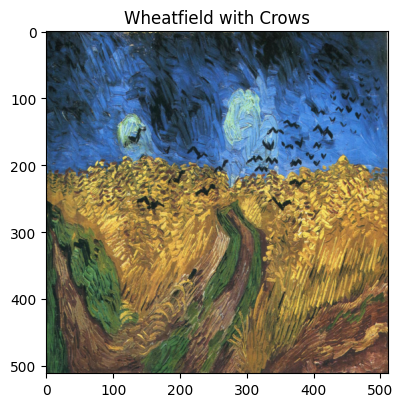

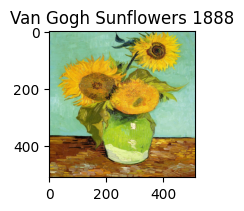

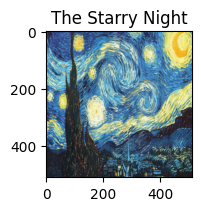

In [33]:
# 1. טעינת שלוש התמונות לזיכרון
path1 = "/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_wheatfield-with-crows-1890.jpg"
path2 = "/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_sunflowers-1888.jpg"
path3 = "/kaggle/input/wikiart/Post_Impressionism/vincent-van-gogh_the-starry-night-1889(1).jpg"

style_img1 = image_loader(path1)
style_img2 = image_loader(path2)
style_img3 = image_loader(path3)

# 2. הצגת שלוש התמונות זו לצד זו
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
imshow(style_img1, title="Wheatfield with Crows")

plt.subplot(1, 3, 2)
imshow(style_img2, title="Van Gogh Sunflowers 1888")

plt.subplot(1, 3, 3)
imshow(style_img3, title="The Starry Night")

plt.show()

In [46]:
def get_features(image, model, layers_dict):
    """חילוץ מפות אקטיבציה משכבות נבחרות במודל"""
    features = {}
    x = image
    # שים לב לשינוי כאן: הורדנו את .features
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers_dict:
            features[layers_dict[name]] = x
    return features

In [47]:
def neural_style_transfer(model, content_image, style_image, 
                          content_layers, style_layers, 
                          content_weight, style_weight, 
                          style_layer_weights):
    """
    Neural style transfer
    """
    # א. הכנת המודל למצב הערכה והקפאת גרדיאנטים (כי המודל לא לומד)
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    
    # ב. אתחול תמונת היעד (Target) כתצלום של תמונת התוכן
    target = content_image.clone().requires_grad_(True)
    
    # ג. יצירת מילוי שמות השכבות (Mapping)
    # אנו מאחדים את כל השכבות המבוקשות למילון אחד לצורך חילוץ
    all_layers = {**content_layers, **style_layers}
    
    # ד. חילוץ תכונות קבועות מראש מתמונות המקור
    content_features = get_features(content_image, model, content_layers)
    style_features = get_features(style_image, model, style_layers)
    
    # ה. חישוב מטריצות גראם לתמונת הסגנון
    style_grams = {layer: get_gram_matrix(style_features[layer]) for layer in style_features}

    # ו. הגדרת האופטימייזר (LBFGS מומלץ לאיכות מקסימלית ב-NST)
    optimizer = optim.LBFGS([target])
    
    num_steps = 300 # מספר איטרציות קבוע ################################### IMPORTANT TO SET ##########################################
    
    # ז. לולאת האופטימיזציה
    print("Starting optimization...")
    for i in range(num_steps):
        def closure():
            optimizer.zero_grad()
            
            # חילוץ תכונות נוכחיות מתמונת היעד
            target_features = get_features(target, model, all_layers)
            
            # 1. חישוב Content Loss
            c_loss = 0
            for layer in content_layers.values():
                c_loss += torch.mean((target_features[layer] - content_features[layer])**2)
            
            # 2. חישוב Style Loss
            s_loss = 0
            for layer in style_layers.values():
                target_gram = get_gram_matrix(target_features[layer])
                style_gram = style_grams[layer]
                # שקלול של כל שכבת סגנון בנפרד
                layer_weight = style_layer_weights.get(layer, 1.0)
                s_loss += layer_weight * torch.mean((target_gram - style_gram)**2)
            
            # 3. Total Loss משוקלל (α ו-β)
            total_loss = content_weight * c_loss + style_weight * s_loss
            total_loss.backward()
            
            return total_loss

        optimizer.step(closure)
        
    # ח. החזרת התמונה הסופית
    return target.detach()

In [48]:
# מיפוי אינדקס השכבה לשם סמנטי
content_layers = {'21': 'content'}

style_layers = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '28': 'conv5_1'
}

# משקולות פנימיות לכל שכבת סגנון (Style Layer Weights)
# בדרך כלל נותנים משקל שווה לכולן בהתחלה
style_layer_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.8,
    'conv3_1': 0.5,
    'conv4_1': 0.3,
    'conv5_1': 0.1
}

# משקולות גלובליות (Alpha ו-Beta)
content_weight = 1e-2  # אלפא - כמה לשמור על התמונה המקורית
style_weight = 1e6     # בטא - כמה להפוך אותה ל"ואן גוך"

### load out model

In [49]:
import torchvision.models as models

# טעינת VGG-19 עם משקולות מאימון קודם
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# הקפאת כל הפרמטרים - המודל לא לומד, הוא רק "מבקר"
for param in vgg.parameters():
    param.requires_grad = False

print("VGG-19 loaded and frozen.")

VGG-19 loaded and frozen.


In [50]:
# our Content Image
picture_dir = "/kaggle/input/content/content.jpg"
content_img_tensor = image_loader(picture_dir)

Starting optimization...


/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


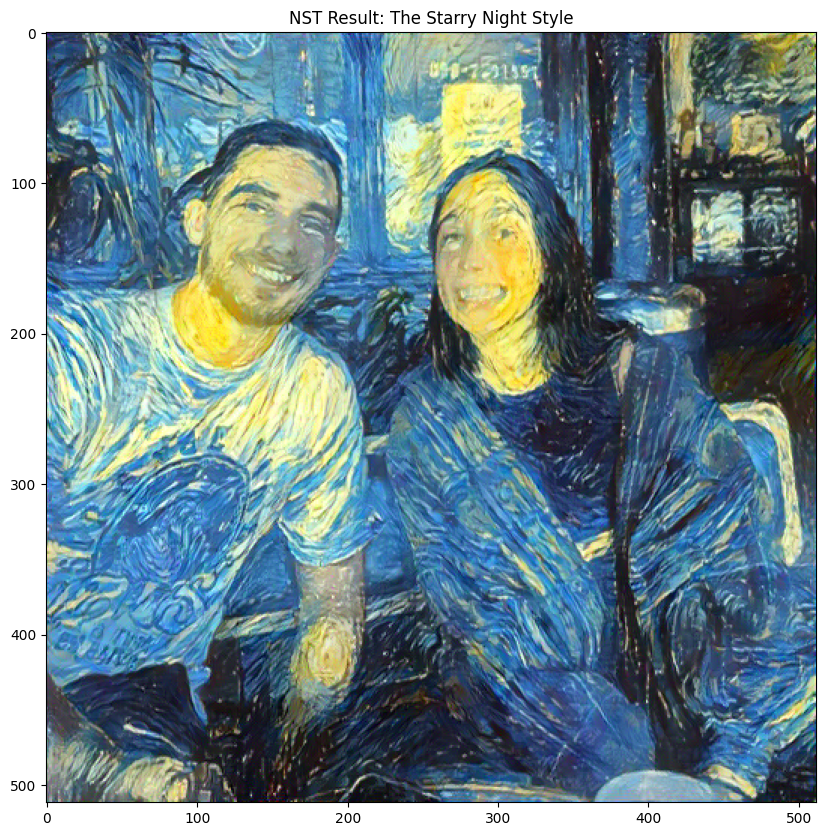

In [51]:
# נבחר את ליל כוכבים לניסוי הראשון
current_style_img = style_img3 
content_img=content_img_tensor
# הגדרת משקולות האופטימיזציה
content_weight = 1e-2 # אלפא
style_weight = 1e6    # בטא

# הרצת הפונקציה (וודא שהגדרת את neural_style_transfer בתא קודם)
final_result = neural_style_transfer(
    vgg, content_img, current_style_img,
    content_layers, style_layers,
    content_weight, style_weight,
    style_layer_weights
)

# הצגת התוצאה
plt.figure(figsize=(10, 10))
imshow(final_result, title="NST Result: The Starry Night Style")
plt.show()

# HyperParameter search

In [ ]:
import torch.nn.functional as F
import optuna

def objective(trial):
    # 1. הצעה של היפר-פרמטרים (בסקאלה לוגריתמית)
    # אנחנו מחפשים את היחס הנכון בין אלפא לבטא
    c_weight = trial.suggest_float("content_weight", 1e-4, 1e2, log=True)
    s_weight = trial.suggest_float("style_weight", 1e3, 1e9, log=True)

    # 2. הרצת ה-Style Transfer
    # טיפ: לצורך החיפוש, כדאי להוריד את num_steps ל-50 או 100 כדי לחסוך זמן
    stylized_image = neural_style_transfer(
        vgg, content_img, style_img, 
        content_layers, style_layers, 
        c_weight, s_weight, 
        style_layer_weights
    )

    # 3. הכנת התמונה ל"שופט" (AlexNet)
    # א. שינוי גודל ל-224x224
    # ב. הנורמליזציה כבר קיימת בתוך ה-NST (בשלב ה-Target), 
    # אבל נוודא שהערכים בטווח המתאים לשופט
    judge_input = F.interpolate(stylized_image, size=(224, 224), mode='bilinear', align_corners=False)
    
    # 4. קבלת ציון מהשופט
    with torch.no_grad():
        output = judge_model(judge_input) # judge_model הוא ה-AlexNet מחלק 1
        probabilities = F.softmax(output, dim=1)
        
    # נניח שאינדקס 0 הוא "Van Gogh" (בדוק מה האינדקס אצלך לפי ה-ImageFolder)
    van_gogh_prob = probabilities[0][0].item()

    return van_gogh_prob

In [ ]:
# יצירת מחקר חדש שמטרתו למקסם את הציון
study = optuna.create_study(direction="maximize")

# הרצת 15 ניסיונות (Trials)
# כל ניסוי ייקח כ-30-60 שניות ב-GPU
study.optimize(objective, n_trials=15)

print("Best Parameters found:", study.best_params)
print("Highest Score from Judge:", study.best_value)